# Calculate Agreement and Merge Labels

We calculate agreement among the categories we pushed to MTurk for each task's file and for each category.

We then use majority voting to label tweets by their categories and export the resulting data to a CSV.

In [1]:
%matplotlib inline

import random
import requests
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.inter_rater import fleiss_kappa
from statsmodels.stats.inter_rater import to_table
from statsmodels.stats.inter_rater import aggregate_raters
from sklearn.metrics import cohen_kappa_score

## Define Labels

Specify the mapping between labels and MTurk category names.

In [2]:
label_names = ["Abusive", "Affectionate", "Lyrics", "Self", "Adult", "Not English", "Other"]

label_map = {"category %d" % (i+1):l for i,l in enumerate(label_names)}
label_map

{'category 1': 'Abusive',
 'category 2': 'Affectionate',
 'category 3': 'Lyrics',
 'category 4': 'Self',
 'category 5': 'Adult',
 'category 6': 'Not English',
 'category 7': 'Other'}

## Merge MTurk Batch Results

In [3]:
dfs = []

for csv_f in glob.glob("./mturk_raw/Batch_*.csv"):
    local_df = pd.read_csv(csv_f)
    dfs.append((csv_f, local_df))

final_df = pd.concat([tup[1] for tup in dfs], sort=True)

In [4]:
print(final_df.shape)
final_df[["Input.tweet_url", "Answer.categories"]].groupby("Answer.categories").count()

(2793, 32)


,Input.tweet_url
Answer.categories,
category 1,1893
category 2,306
category 3,121
category 4,192
category 5,15
category 6,3
category 7,263


## Find All Labels For Each Tweet

Iterate through our list of labels and find each category for each tweet. We'll put these categories into a dictionary that maps tweet URLs to the list of category labels that URL has received.

In [5]:
answer_map = {}

for idx, row in final_df[["Input.tweet_url", "Answer.categories"]].iterrows():

    # Replace category with a number
    cat_num = int(row[1].replace("category ", ""))

    # Add the numeric category to the list of labels for this tweet
    cat_list = answer_map.get(row[0], []) + [cat_num]
    
    # Update answers for this tweet
    answer_map[row[0]] = cat_list
    

In [6]:
# Get the list of labels for each item
three_label_data = [tup[1] for tup in answer_map.items()]

# Aggregate these labels rows of counts per label
three_label_table, three_label_cats = aggregate_raters(three_label_data)

# Calculate Fleiss's kappa for this data
fleiss = fleiss_kappa(three_label_table)

print("Fleiss Kappa:", fleiss)

Fleiss Kappa: 0.28410664785343254


## Generate Labels Based on Majority Vote for Each Tweet

In [7]:
def find_vote(labels):
    '''
    Find the most common label, if it exists. 
    If no unique most-common label exists, return None
    '''
    label_set = set(labels)
    
    if ( len(label_set) == 1 ):
        return label_set.pop()
    else:
        label_counts = dict([(l, sum([1 if x==l else 0 for x in labels])) for l in label_set])

        sorted_votes = sorted(label_counts, key=label_counts.get)
        high = sorted_votes[-1]
        next_high = sorted_votes[-2]

        if ( label_counts[high] == label_counts[next_high] ):
            return None
        else:
            return sorted_votes[-1]

Majority: 849 of 931


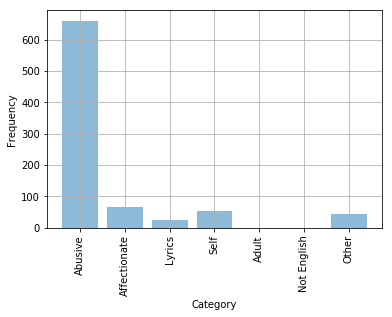

In [8]:
actual_labels = [find_vote(l) for l in answer_map.values()]
label_counts = dict([(x, 0) for x in range(1, 8)])

has_majority = list(filter(lambda x: x != None, actual_labels))
print("Majority:", len(has_majority), "of", len(actual_labels))

for l in has_majority:
    label_counts[l] += 1

x_pos = range(len(label_counts))
y_val = [label_counts[x] for x in sorted(label_counts.keys())]


plt.bar(x_pos, y_val, align='center', alpha=0.5)
plt.xticks(x_pos, label_names, rotation=90)
plt.ylabel("Frequency")
plt.xlabel("Category")
plt.grid()
plt.show()

## Failure Analysis

Show tweets where we don't have a majority vote.

In [9]:
for url, votes in answer_map.items():
    if ( find_vote(votes) is None ):
        req = requests.get(url)
        print(votes, str(req.text.encode("utf8"), "utf8", errors="replace"))
        print()
        

[3, 4, 1] <p>I'm so high high high that a bitch can't blow my high</p>

[4, 1, 7] <p>what are the criterias that are necessary for a girl to be referred to as a whore??</p>

[2, 1, 7] <p>@MrRPMurphy @ladygaga BITCH YOU BETTER SAY YES!!!!!!!!</p>

[1, 4, 3] <p>Fuck I look like hoe? I look like yes and you look like no</p>

[1, 2, 7] <p>Studying can become a revolting bitch at times &gt;_&gt;</p>

[1, 2, 7] <p>@S_lina_ i was like really bitch is it? ð</p>

[2, 1, 7] <p>Any cunt want to start a band?</p>

[2, 4, 3] <p>That my bitch forever eva. The love we got is forever eva</p>

[5, 6, 7] <p>@ItsJasonDidee I cunt go until May ð¢</p>

[4, 1, 7] <p>I wish I had a bitch like me ð©</p>

[7, 4, 3] <p>"Tell them if he's not part of the solution he is part of the problem then say bitch better have my money"- the shit my dad says ð</p>

[2, 1, 7] <p>You don't call your girlfriend a hoe. Where the real guys at</p>

[7, 1, 2] <p>Found a house party bitch!!!!!</p>

[2, 7, 1] <p>where is m

## Collect Twitter URLs and their Labels

In [10]:
vote_map = {x:[] for x in range(1,8)}

for url, votes in answer_map.items():
    label = find_vote(votes)
    if ( label is not None ):
        vote_map[label].append(url)
        

## Randomly Sample Tweets with Labels

We take a random sample of these labeled tweets for human review.

In [11]:
from IPython.core.display import display, HTML

for k in vote_map.keys():
    tweet_urls = vote_map[k]
    if ( len(tweet_urls) < 20 ):
        continue
        
    print("Label:", label_names[k-1])
    samp = random.sample(tweet_urls, 20)
    for url in samp:
        r = requests.get(url)
        print("\t", url, r.content.decode("utf8"))
#         display(HTML())
    
    print()

Label: Abusive
	 https://s3.amazonaws.com/misexp/255.html <p>@HiiipowerDaidai come open the door bitch</p>
	 https://s3.amazonaws.com/misexp/176.html <p>@JermBuggg bitch I know you seen my text</p>
	 https://s3.amazonaws.com/misexp/419.html <p>Call the police bitch nigga. CALL THEM.</p>
	 https://s3.amazonaws.com/misexp/538.html <p>Bitch won't get off his phone</p>
	 https://s3.amazonaws.com/misexp/599.html <p>Try me bitch 😂😂😂😂</p>
	 https://s3.amazonaws.com/misexp/929.html <p>what the fuck did you just say about me, you little bitch?</p>
	 https://s3.amazonaws.com/misexp/265.html <p>Looking like Popeye. Yo bitch love the semen</p>
	 https://s3.amazonaws.com/misexp/501.html <p>Boo bitch bye!👋🏽</p>
	 https://s3.amazonaws.com/misexp/157.html <p>I had to put that lil bitch in her place</p>
	 https://s3.amazonaws.com/misexp/386.html <p>I could put a bitch on like worldstar</p>
	 https://s3.amazonaws.com/misexp/540.html <p>Wish a bitch would ☺️☺️☺️☺️</p>
	 https://s3.amazonaws.com/misexp/20

	 https://s3.amazonaws.com/misexp/158.html <p>@misguidedLight I'M A FREE BITCH BABY</p>
	 https://s3.amazonaws.com/misexp/390.html <p>Bitch please, i'm parawhore 💁</p>
	 https://s3.amazonaws.com/misexp/876.html <p>I don't wanna be in a relationship = I wanna be a hoe</p>
	 https://s3.amazonaws.com/misexp/723.html <p>Bitch I'm The Devil‼️‼️‼️‼️‼️‼️💁🏽😈</p>
	 https://s3.amazonaws.com/misexp/342.html <p>@X_T_M_ i'm a like whore :p</p>
	 https://s3.amazonaws.com/misexp/263.html <p>I'm one sexy bitch</p>
	 https://s3.amazonaws.com/misexp/253.html <p>"You look mean" 
Bitch I am mean. Bye.</p>

Label: Other
	 https://s3.amazonaws.com/misexp/880.html <p>My block button lost her virginity like seconds after I created my Twitter, and I still tap that hoe dailyyy ✌🏼️🙂</p>
	 https://s3.amazonaws.com/misexp/782.html <p>Works going to be a bitch tomorrow</p>
	 https://s3.amazonaws.com/misexp/313.html <p>Bengals 🐅 🏉 Bitch ❗️❗️❗️❗️ #WhoDey</p>
	 https://s3.amazonaws.com/misexp/807.html <p>It's Britney 

## Extract the HTML Index Number from Each Tweet

We use the index number (xxx.html) as a key for mapping back to the original tweet ID.

In [12]:
data_list = []

for label, tweet_list in vote_map.items():
    print(label)
    
    for tweet in tweet_list:
        index = tweet.replace("https://s3.amazonaws.com/misexp/", "").replace(".html", "")
        data_list.append({"id":index, "label":label})

1
2
3
4
5
6
7


In [13]:
output_df = pd.DataFrame(data_list)
output_df.index = output_df.id.apply(lambda x: int(x))

## Connect Labels to Text

In [14]:
samples_to_label = pd.read_json("../00_misogyny_tweet_sampling/misogyny_en_samples_to_label.json")
samples_to_label.columns = ["text"]

In [15]:
labeled_text_df = samples_to_label.join(output_df).dropna()

## Create One-Hot Encodings for the Labels

To make things easier to read from the CSV file, we convert label IDs to a one-hot encoded columns with the appropriate names.

In [20]:
for label_index, label_name in enumerate(label_names):
    labeled_text_df[label_name] = labeled_text_df["label"].apply(lambda l: 1 if int(l)-1 == label_index else 0)

In [21]:
labeled_text_df.to_csv("mturk_labeled_tweet_text.csv", index=False)